In [1]:
# interactive figure
%matplotlib widget

# auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import cmocean
import warnings
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import matplotlib.gridspec as gridspec
from scipy import integrate
from dask_jobqueue import PBSCluster
from dask.distributed import LocalCluster, Client
from matplotlib.colors import Normalize
from sys import platform
from xgcm import Grid
from viztool import pcolor_center, pcolor_limits, get_pdf_of_icdf, config_colorbar, create_register_cmaps
# from spectrum import Gaussian_filter_2d
# from spectrum import TWODimensional_spec
from mixdiag import double_front_boundary, get_bld_Rib, get_mld_PE_anomaly, interp_to_zi

In [3]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/TracerInversion/Data/'
else:
    print('OS not supported.')

create_register_cmaps()

In [4]:
def config_PBSCluster(mem_per_worker, hostname=None):
    if hostname is None: hostname = os.environ.get('NCAR_HOST')
    job_directives = ['-j oe', '-A UMCP0020']
    if hostname == 'derecho':
        queue_type = 'develop'
        job_directives = job_directives.append('-l job_priority=economy')
    elif hostname == 'casper':
        queue_type = 'casper'
    SCRATCH = os.getenv('SCRATCH')
    TMPDIR  = f'{SCRATCH}/temp'
    job_script_prologue = [f'export TMPDIR={TMPDIR}', 'mkdir -p $TMPDIR']
    cluster_kw = dict(job_name='dask_worker_derecho',
                      cores=1,
                      memory=f'{mem_per_worker}GiB',
                      processes=1,
                      local_directory=f'{SCRATCH}/dask/derecho/local-dir',
                      log_directory=f'{SCRATCH}/dask/derecho/logs',
                      job_extra_directives=job_directives,
                      job_script_prologue=job_script_prologue,
                      resource_spec=f'select=1:ncpus=1:mem={mem_per_worker}GB',
                      scheduler_options={'dashboard_address': ':8787'},
                      queue=queue_type,
                      walltime='02:00:00',
                      interface='hsn0')
    return cluster_kw

In [5]:
def Ifske_budget_without_VSPuv(ds, filter_taper, dxF, dyF, dzF, grid):
    uu = ds.u * ds.u
    uv = ds.u * ds.v
    uw = ds.u * ds.w
    vv = ds.v * ds.v
    vw = ds.v * ds.w
    ww = ds.w * ds.w
    wb = ds.w * ds.b
    wc = ds.w * ds.c
    vc = ds.v * ds.c
    uc = ds.u * ds.c

    uu.name = 'uu'
    uv.name = 'uv'
    uw.name = 'uw'
    vv.name = 'vv'
    vw.name = 'vw'
    ww.name = 'ww'
    wb.name = 'wb'
    wc.name = 'wc'
    vc.name = 'vc'
    uc.name = 'uc'
    dsf = xr.merge([uu, uv, uw, vv, vw, ww, wb, wc, vc, uc])

    dsl = filter_taper.apply(ds,  dims=['yC', 'xC'])
    dsf = filter_taper.apply(dsf, dims=['yC', 'xC'])
    dsf['uu'] = dsf.uu - (dsl.u * dsl.u)
    dsf['uv'] = dsf.uv - (dsl.u * dsl.v)
    dsf['uw'] = dsf.uw - (dsl.u * dsl.w)
    dsf['vv'] = dsf.vv - (dsl.v * dsl.v)
    dsf['vw'] = dsf.vw - (dsl.v * dsl.w)
    dsf['ww'] = dsf.ww - (dsl.w * dsl.w)
    dsf['wb'] = dsf.wb - (dsl.w * dsl.b)
    dsf['wc'] = dsf.wc - (dsl.w * dsl.c)
    dsf['vc'] = dsf.vc - (dsl.v * dsl.c)
    dsf['uc'] = dsf.uc - (dsl.u * dsl.c)
    dsf['fske'] = (dsf.uu + dsf.vv + dsf.ww) / 2

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        b_xf = grid.interp(dsl.b, axis='x').transpose(..., 'xF')
        b_yf = grid.interp(dsl.b, axis='y').transpose(..., 'yF')
        u_xf = grid.interp(dsl.u, axis='x').transpose(..., 'xF')
        u_yf = grid.interp(dsl.u, axis='y').transpose(..., 'yF')
        v_xf = grid.interp(dsl.v, axis='x').transpose(..., 'xF')
        v_yf = grid.interp(dsl.v, axis='y').transpose(..., 'yF')
        w_xf = grid.interp(dsl.w, axis='x').transpose(..., 'xF')
        w_yf = grid.interp(dsl.w, axis='y').transpose(..., 'yF')

        dbdx = grid.diff(b_xf, axis='x') / dxF
        dbdy = grid.diff(b_yf, axis='y') / dyF

        dudx = grid.diff(u_xf, axis='x') / dxF
        dudy = grid.diff(u_yf, axis='y') / dyF

        dvdx = grid.diff(v_xf, axis='x') / dxF
        dvdy = grid.diff(v_yf, axis='y') / dyF

        dwdx = grid.diff(w_xf, axis='x') / dxF
        dwdy = grid.diff(w_yf, axis='y') / dyF

    dsl['δ']  = dudx + dvdy
    dsl['σₛ'] = dvdx + dudy
    dsl['σₙ'] = dudx - dvdy
    dsl['M²'] = np.sqrt(dbdx**2 + dbdy**2)

    dsf['HSP_δ'] = - (dsf.uu + dsf.vv) * dsl['δ']  / 2
    dsf['HSP_σ'] = - (dsf.uu - dsf.vv) * dsl['σₙ'] / 2 - dsf.uv * dsl['σₛ']
    dsf['VSP_w'] = -  dsf.uw * dwdx - dsf.vw * dwdy + dsf.ww * dsl['δ']

    M2l = dsl['M²'].where(dsl.zC >= -dsl.Hm).mean('zC')/dsl.attrs['M²']
    dsl['mask_fz'] = double_front_boundary(M2l, Mc=0.2, in_km=0, out_km=0)

    dsf['Ifske'] = (dsf.fske.transpose(..., 'zC') * dzF).sum('zC')
    dsf['IVBP']  = (dsf.wb.transpose(..., 'zC')   * dzF).sum('zC')
    dsf['IHSP_δ'] = (dsf['HSP_δ'].transpose(..., 'zC') * dzF).sum('zC')
    dsf['IHSP_σ'] = (dsf['HSP_σ'].transpose(..., 'zC') * dzF).sum('zC')
    dsf['IVSP_w'] = (dsf['VSP_w'].transpose(..., 'zC') * dzF).sum('zC')

    var_dsl_to_save   = ['u', 'v', 'w', 'b', 'c', 'mask_fz', 'xF', 'yF', 'zF']
    var3d_dsf_to_save = ['uw', 'vw', 'wb', 'wc', 'vc', 'uc']
    var2d_dsf_to_save = ['Ifske', 'IVBP', 'IHSP_δ', 'IHSP_σ', 'IVSP_w']

    dsl_save = xr.merge([dsl[var_dsl_to_save], dsf[var3d_dsf_to_save]])
    dsf_save = dsf[var2d_dsf_to_save]
    return dsl_save, dsf_save

def Ifske_budget_VSPuv(dsl, coords):
    grid = Grid(dsl, coords=coords)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        u_zf = grid.interp(dsl.u, axis='z', boundary='extend').transpose(..., 'zF')
        v_zf = grid.interp(dsl.v, axis='z', boundary='extend').transpose(..., 'zF')
        du = grid.diff(u_zf, axis='z')
        dv = grid.diff(v_zf, axis='z')
    IVSP_uv = (-dsl.uw.transpose(..., 'zC') * du).sum('zC') + (-dsl.vw.transpose(..., 'zC') * dv).sum('zC')
    return IVSP_uv

### Load data

In [6]:
cluster = LocalCluster(n_workers=128, threads_per_worker=1, memory_limit='1.8GB',
                       local_directory='/glade/derecho/scratch/zhihuaz/temp', dashboard_address=':8787')
client = Client(cluster)

In [7]:
# cname = 'd11_M003_Ri020_em01_Q000_W000_D000_St0_init-tracer-fluxed'
cname = 'd11_M003_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'
# cname = 'd11_M003_Ri020_em01_Q004_W000_D000_St0_init-tracer-fluxed'

# cname = 'd11_M009_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'
# cname = 'd11_M009_Ri020_em01_Q000_W000_D000_St0_init-tracer-fluxed'

isubset_z_time = dict(zC=slice(19,None), zF=slice(19,None), time=slice(2,146,3))
hr = 1
ihr = int(hr - 1)
ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(isubset_z_time).isel(time=slice(ihr,ihr+2)).chunk(time=1, zC=5)
ds.close()

ds = ds.drop_vars(['c7'])
ds = ds.rename_vars({'c8': 'c'})
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (zC: 45, zF: 46, xC: 2000, yF: 1000, xF: 2000, yC: 1000, time: 2)
Coordinates:
  * zC       (zC) float32 180B -75.6 -73.9 -72.19 ... -4.246 -2.548 -0.8492
  * zF       (zF) float32 184B -76.46 -74.75 -73.05 -71.34 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) timedelta64[ns] 16B 6 days 01:00:00 6 days 02:00:00
Data variables:
    v        (time, zC, yC, xC) float32 720MB dask.array<chunksize=(1, 5, 1000, 2000), meta=np.ndarray>
    c        (time, zC, yC, xC) float32 720MB dask.array<chunksize=(1, 5, 1000, 2000), meta=np.ndarray>
    w        (time, zC, yC, xC) float32 720MB dask.array<chunksize=(1, 5, 1000, 2000), meta=np.ndarray>
    b        (time, zC, yC, xC) float32 720MB dask.array<chunksize=(1, 5, 1000, 2000), meta=np.ndarray>
    u        (time, zC, yC, xC) float32 720MB dask.array<chunksize=(1, 5, 1000, 2000), meta=np.ndarray>
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M003_Ri020_em01_Q001_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   20.0
    ckp_prefix:             with-tracer-fluxed

In [8]:
dxF = (ds.xF[1] - ds.xF[0]).data
dyF = (ds.yF[1] - ds.yF[0]).data
dzF = ds.zF.diff('zF').data
periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'xy'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xyz', 'PPN')}
grid = Grid(ds, coords=coords)

In [9]:
filter_taper = gcm_filters.Filter(filter_scale=100,
                                  dx_min=dxF,
                                  filter_shape=gcm_filters.FilterShape.TAPER,
                                  transition_width=np.pi*4,
                                  grid_type=gcm_filters.GridType.REGULAR,
                                 )

In [10]:
%%time
# with LocalCluster(**cluster_kw) as cluster, Client(cluster) as client:
dsl, dsf = Ifske_budget_without_VSPuv(ds, filter_taper, dxF, dyF, dzF, grid)
dsf = dsf.persist()

delayed_nc_dsl = dsl.to_netcdf(data_dir + cname + f'/hr{hr:02d}_filtered.nc', compute=False)
delayed_nc_dsl.compute()

dsl = xr.open_dataset(data_dir + cname + f'/hr{hr:02d}_filtered.nc', decode_timedelta=True).chunk(xC=200, yC=200, time=1)
dsl.close()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    b_zf = grid.interp(dsl.b, axis='z', boundary='extend').transpose(..., 'zF')
    u_zf = grid.interp(dsl.u, axis='z', boundary='extend').transpose(..., 'zF')
    v_zf = grid.interp(dsl.v, axis='z', boundary='extend').transpose(..., 'zF')

    dbdz = grid.diff(b_zf, axis='z') / dzF
    du   = grid.diff(u_zf, axis='z')
    dv   = grid.diff(v_zf, axis='z')

dsf['IVSP_uv'] = - (dsl.uw.transpose(..., 'zC') * du + dsl.vw.transpose(..., 'zC') * dv).sum('zC')
dsf['bld'] = get_bld_Rib(dsl.zF, dzF, dsl.b, dsl.u, dsl.v, dbdz, dsl.attrs, Ribc=0.3)

uniform_zF  = np.arange(np.ceil(dsl.zF[0]), 1)
uniform_zC  = (uniform_zF[:-1] + uniform_zF[1:]) / 2
uniform_dzF = np.diff(uniform_zF)
dsf['mld']  = get_mld_PE_anomaly(uniform_dzF,
                                 dsl.b.interp(zC=uniform_zC, kwargs={'fill_value': 'extrapolate'}),
                                 dsl.attrs, energy=0.1)

delayed_nc_dsf = dsf.to_netcdf(data_dir + cname + f'/hr{hr:02d}_Ifske_budget.nc', compute=False)
delayed_nc_dsf.compute()

CPU times: user 1min 57s, sys: 2min 59s, total: 4min 56s
Wall time: 5min 4s


In [ ]:
%%time
a, b = Ifske_budget_without_VSPuv(ds.isel(time=slice(0,2)), filter_taper, dxF, dyF, dzF, coords)
delayed_nc_dsli = a.to_netcdf(data_dir + cname + f'/hr{1:02d}_filtered.nc', compute=False)
delayed_nc_dsli.compute()

In [11]:
cluster_kw = config_PBSCluster(3)

In [12]:
%%time
with PBSCluster(**cluster_kw) as cluster, Client(cluster) as client:
    cluster.scale(64)
    
    a, b = Ifske_budget_without_VSPuv(ds.isel(time=slice(2,4)), filter_taper, dxF, dyF, dzF, coords)
    delayed_nc_dsli = a.to_netcdf(data_dir + cname + f'/hr{2:02d}_filtered.nc', compute=False)
    delayed_nc_dsli.compute()

CPU times: user 36.4 s, sys: 2.32 s, total: 38.7 s
Wall time: 8min 54s


In [ ]:
%%time
for itime in range(0, 48, 2):# 48
    ihr = int(itime + 1)
    print(f'Hour {ihr:02d}...')
    dsi = ds.isel(time=slice(itime, itime+2))
    dsli_save, dsfi_save = Ifske_budget_without_VSPuv(dsi, filter_taper, dxF, dyF, dzF, coords)
    dsfi_save = dsfi_save.persist()

    delayed_nc_dsli = dsli_save.to_netcdf(data_dir + cname + f'/hr{ihr:02d}_filtered.nc', compute=False)
    delayed_nc_dsli.compute()

    print('Adding integrated VSP\n')
    dsli = xr.open_dataset(data_dir + cname + f'/hr{ihr:02d}_filtered.nc', decode_timedelta=True).chunk(xC=200, yC=200)
    dsli.close()

    dsfi_save['IVSP_uv'] = Ifske_budget_VSPuv(dsli, coords)
    delayed_nc_dsfi = dsfi_save.to_netcdf(data_dir + cname + f'/hr{ihr:02d}_Ifske_budget.nc', compute=False)
    delayed_nc_dsfi.compute()

Hour 01...


### Load processed data

In [4]:
# cluster = LocalCluster(n_workers=13, threads_per_worker=2, memory_limit='18GB',
#                        local_directory='/glade/derecho/scratch/zhihuaz/temp', dashboard_address=':8787')
cluster = LocalCluster(n_workers=12, threads_per_worker=1, memory_limit='16GB',
                       local_directory='/glade/derecho/scratch/zhihuaz/temp', dashboard_address=':8787')
client = Client(cluster)

/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.94s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


In [5]:
# cname = 'd11_M003_Ri020_em01_Q000_W000_D000_St0_init-tracer-fluxed'
# cname = 'd11_M003_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'

# cname = 'd11_M006_Ri020_em01_Q000_W000_D000_St0_init-tracer-fluxed'
# cname = 'd11_M006_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'
cname = 'd11_M006_Ri020_em01_Q004_W000_D000_St0_init-tracer-fluxed'

periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'xy'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xyz', 'PPN')}

In [6]:
dsf = xr.open_mfdataset(data_dir + cname + '/hr*_Ifske_budget.nc', decode_timedelta=False, combine='nested', concat_dim='time').chunk(time=1)
dsf.close()
dsf

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 48, yC: 1000, xC: 2000)
Coordinates:
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) float64 384B 3.492e+05 3.528e+05 ... 5.148e+05 5.184e+05
Data variables:
    Ifske    (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    IVBP     (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    IHSP_δ   (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    IHSP_σ   (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    IVSP_w   (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    IVSP_uv  (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    bld      (time, yC, xC) float64 768MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>

In [7]:
dsf['IHSP'] = dsf['IHSP_δ'] + dsf['IHSP_σ']
dsf['IVSP'] = dsf['IVSP_w'] + dsf['IVSP_uv']
dsf['ISP']  = dsf['IHSP']   + dsf['IVSP']
dsf['hour'] = (dsf.time - dsf.time[0])/1e9/3600

In [10]:
dsf.bld.isel(xC=slice(0,200)).mean(['xC', 'yC']).load().mean()

<xarray.DataArray 'bld' ()> Size: 8B
array(20.4431288)

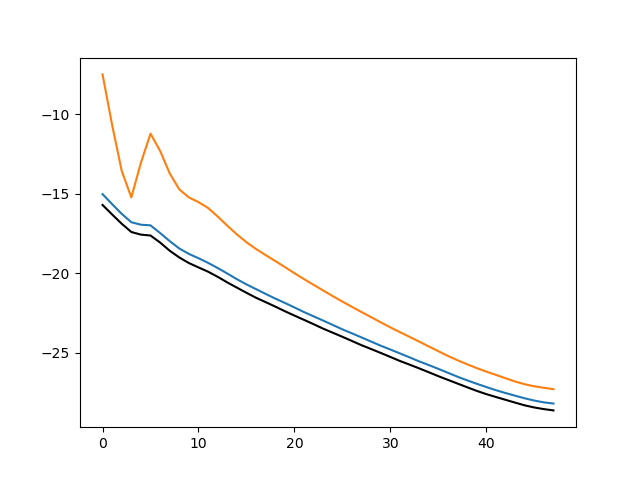

In [20]:
plt.close()
plt.figure()
plt.plot(-dsf.mld.isel(xC=slice(0,200)).mean(['xC', 'yC']))
plt.plot(-dsf.bld.isel(xC=slice(0,200)).mean(['xC', 'yC']))
plt.plot(-dsl.mld.isel(xC=slice(0,200)).mean(['xC', 'yC']), 'k');

In [8]:
isubset_z_time = dict(zC=slice(19,None), zF=slice(19,None), time=slice(2,146,3))
ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=False).isel(isubset_z_time).chunk(time=1)
ds.close()

ds = ds.drop_vars(['c7'])
ds = ds.rename_vars({'c8': 'c'})
ds['cflux0'] = -1e-3 * (1 - ds.c.isel(zC=-1))
ds

<xarray.Dataset> Size: 87GB
Dimensions:  (zC: 45, zF: 46, xC: 2000, yF: 1000, xF: 2000, yC: 1000, time: 48)
Coordinates:
  * zC       (zC) float32 180B -75.6 -73.9 -72.19 ... -4.246 -2.548 -0.8492
  * zF       (zF) float32 184B -76.46 -74.75 -73.05 -71.34 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) float64 384B 3.492e+05 3.528e+05 ... 5.148e+05 5.184e+05
Data variables:
    v        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    c        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    w        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    b        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    u        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    cflux0   (time, yC, xC) float32 384MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M006_Ri020_em01_Q004_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   20.0
    ckp_prefix:             Q004_with-tracer-fluxed

In [158]:
dxF = ds.xF.diff('xF').data[0]
dyF = ds.yF.diff('yF').data[0]
dzF = ds.zF.diff('zF').data
grid = Grid(ds, coords=coords)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    b_xf = grid.interp(ds.b, axis='x').transpose(..., 'xF')
    b_yf = grid.interp(ds.b, axis='y').transpose(..., 'yF')
    b_zf = grid.interp(ds.b, axis='z', boundary='extend').transpose(..., 'zF')

    c_xf = grid.interp(ds.c, axis='x').transpose(..., 'xF')
    c_yf = grid.interp(ds.c, axis='y').transpose(..., 'yF')
    c_zf = grid.interp(ds.c, axis='z', boundary='extend').transpose(..., 'zF')

    ds['dbdx'] = grid.diff(b_xf, axis='x') / dxF
    ds['dbdy'] = grid.diff(b_yf, axis='y') / dyF
    ds['dbdz'] = grid.diff(b_zf, axis='z') / dzF

    ds['dcdx'] = grid.diff(c_xf, axis='x') / dxF
    ds['dcdy'] = grid.diff(c_yf, axis='y') / dyF
    ds['dcdz'] = grid.diff(c_zf, axis='z') / dzF

ds['mGb']  = np.sqrt(ds.dbdx**2 + ds.dbdy**2 + ds.dbdz**2)
ds['nGbx'] = ds.dbdx / ds.mGb
ds['nGby'] = ds.dbdy / ds.mGb
ds['nGbz'] = ds.dbdz / ds.mGb

ds['mGc']  = np.sqrt(ds.dcdx**2 + ds.dcdy**2 + ds.dcdz**2)
ds['nGcx'] = ds.dcdx / ds.mGc
ds['nGcy'] = ds.dcdy / ds.mGc
ds['nGcz'] = ds.dcdz / ds.mGc

In [9]:
bmin = np.floor(75*ds.attrs['N₁²'] * 1e6) / 1e2
bsrf = np.floor((15*ds.attrs['N₁²'] + ds.Hm*ds.attrs['N₀²'] + ds.Lf*ds.attrs['M²']) * 1e6) / 1e2 + bmin
nlev = 25#15
delb0 = np.floor((bsrf - bmin)/nlev * 1e2) / 1e2
blines_upper = np.arange(bmin, bsrf, delb0)*1e-4

In [10]:
dsl = xr.open_mfdataset(data_dir + cname + '/hr*_filtered.nc', decode_timedelta=False, combine='nested', concat_dim='time').chunk(time=1, xC=200, yC=200)
# dsl = xr.open_mfdataset(data_dir + cname + '/hr*_filtered.nc', decode_timedelta=False, combine='nested', concat_dim='time').chunk(zC=15)
dsl.close()

dsl['u_c'] = dsl.u * dsl.c
dsl['v_c'] = dsl.v * dsl.c
dsl['w_c'] = dsl.w * dsl.c
dsl['w_b'] = dsl.w * dsl.b

In [66]:
filter_taper = gcm_filters.Filter(filter_scale=100,
                                  dx_min=4,
                                  filter_shape=gcm_filters.FilterShape.TAPER,
                                  transition_width=np.pi*4,
                                  grid_type=gcm_filters.GridType.REGULAR,
                                 )

In [67]:
uu = ds.u * ds.u
uv = ds.u * ds.v
vv = ds.v * ds.v
ww = ds.w * ds.w
# vb = ds.v * ds.b
# ub = ds.u * ds.b

uu.name = 'uu'
uv.name = 'uv'
vv.name = 'vv'
ww.name = 'ww'
# vb.name = 'vb'
# ub.name = 'ub'

cov = xr.merge([uu, uv, vv, ww])
# cov = xr.merge([uu, uv, vv, ww, vb ,ub])

In [68]:
covl = filter_taper.apply(cov, dims=['yC', 'xC'])

dsl['uu'] = covl.uu - (dsl.u * dsl.u)
dsl['uv'] = covl.uv - (dsl.u * dsl.v)
dsl['vv'] = covl.vv - (dsl.v * dsl.v)
dsl['ww'] = covl.ww - (dsl.w * dsl.w)
# dsl['vb'] = covl.vb - (dsl.v * dsl.b)
# dsl['ub'] = covl.ub - (dsl.u * dsl.b)

/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/dask/array/core.py:5003: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [69]:
dxF = dsl.xF.diff('xF').data[0]
dyF = dsl.yF.diff('yF').data[0]
dzF = dsl.zF.diff('zF').rename({'zF': 'zC'}).assign_coords(zC=dsl.zC).data
grid = Grid(dsl, coords=coords)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bl_xf = grid.interp(dsl.b, axis='x').transpose(..., 'xF')
    bl_yf = grid.interp(dsl.b, axis='y').transpose(..., 'yF')
    bl_zf = grid.interp(dsl.b, axis='z', boundary='extend').transpose(..., 'zF')

    cl_xf = grid.interp(dsl.c, axis='x').transpose(..., 'xF')
    cl_yf = grid.interp(dsl.c, axis='y').transpose(..., 'yF')
    cl_zf = grid.interp(dsl.c, axis='z', boundary='extend').transpose(..., 'zF')

    ul_xf = grid.interp(dsl.u, axis='x').transpose(..., 'xF')
    ul_yf = grid.interp(dsl.u, axis='y').transpose(..., 'yF')
    ul_zf = grid.interp(dsl.u, axis='z', boundary='extend').transpose(..., 'zF')

    vl_xf = grid.interp(dsl.v, axis='x').transpose(..., 'xF')
    vl_yf = grid.interp(dsl.v, axis='y').transpose(..., 'yF')
    vl_zf = grid.interp(dsl.v, axis='z', boundary='extend').transpose(..., 'zF')

    wl_xf = grid.interp(dsl.w, axis='x').transpose(..., 'xF')
    wl_yf = grid.interp(dsl.w, axis='y').transpose(..., 'yF')

    dsl['dbdx'] = grid.diff(bl_xf, axis='x') / dxF
    dsl['dbdy'] = grid.diff(bl_yf, axis='y') / dyF
    dsl['dbdz'] = grid.diff(bl_zf, axis='z') / dzF

    dsl['dcdx'] = grid.diff(cl_xf, axis='x') / dxF
    dsl['dcdy'] = grid.diff(cl_yf, axis='y') / dyF
    dsl['dcdz'] = grid.diff(cl_zf, axis='z') / dzF

    dsl['dudx'] = grid.diff(ul_xf, axis='x') / dxF
    dsl['dudy'] = grid.diff(ul_yf, axis='y') / dyF
    dsl['dudz'] = grid.diff(ul_zf, axis='z') / dzF

    dsl['dvdx'] = grid.diff(vl_xf, axis='x') / dxF
    dsl['dvdy'] = grid.diff(vl_yf, axis='y') / dyF
    dsl['dvdz'] = grid.diff(vl_zf, axis='z') / dzF

    dsl['dwdx'] = grid.diff(wl_xf, axis='x') / dxF
    dsl['dwdy'] = grid.diff(wl_yf, axis='y') / dyF

dsl['mGb']  = np.sqrt(dsl.dbdx**2 + dsl.dbdy**2 + dsl.dbdz**2)
dsl['nGbx'] = dsl.dbdx / dsl.mGb
dsl['nGby'] = dsl.dbdy / dsl.mGb
dsl['nGbz'] = dsl.dbdz / dsl.mGb

dsl['mGc']  = np.sqrt(dsl.dcdx**2 + dsl.dcdy**2 + dsl.dcdz**2)
dsl['nGcx'] = dsl.dcdx / dsl.mGc
dsl['nGcy'] = dsl.dcdy / dsl.mGc
dsl['nGcz'] = dsl.dcdz / dsl.mGc

dsl['mFFc']  = np.sqrt(dsl.uc**2  + dsl.vc**2 +  dsl.wc**2)
dsl['mSFc']  = np.sqrt(dsl.u_c**2 + dsl.v_c**2 + dsl.w_c**2)
dsl['nFFcz'] = (dsl.wc  / dsl.mFFc).where(dsl.mFFc >= 1e-5, other=0)
dsl['nSFcz'] = (dsl.w_c / dsl.mSFc).where(dsl.mSFc >= 1e-5, other=0)

dsl['δ']  = dsl.dudx + dsl.dvdy
dsl['σₙ'] = dsl.dudx - dsl.dvdy
dsl['σₛ'] = dsl.dvdx + dsl.dudy

dsl['HSP_δ'] = - (dsl.uu + dsl.vv) * dsl['δ']  / 2
dsl['HSP_σ'] = - (dsl.uu - dsl.vv) * dsl['σₙ'] / 2 - dsl.uv * dsl['σₛ']
dsl['HSP']   =   dsl['HSP_σ'] + dsl['HSP_δ']
dsl['VSP']   = - dsl.uw * (dsl.dudz + dsl.dwdx) - dsl.vw * (dsl.dvdz + dsl.dwdy) + dsl.ww * dsl['δ']
dsl['fske']  =  (dsl.uu + dsl.vv + dsl.ww) / 2

# dsl['M²'] = np.sqrt(dsl['dbdx']**2 + dsl['dbdy']**2)
# dsl['HTb_δ']  = - dsl['M²']**2 * dsl['δ'] / 2
# dsl['HTb_σ']  = - (dsl.dbdx**2 - dsl.dbdy**2) * dsl['σₙ'] / 2 - dsl.dbdx * dsl.dbdy * dsl['σₛ']
# dsl['Tb_HMX'] = dbHMXdx * dsl.dbdx + dbHMXdy * dsl.dbdy

In [83]:
dsl

<xarray.Dataset> Size: 917GB
Dimensions:  (xF: 2000, yF: 1000, zF: 46, zC: 45, xC: 2000, yC: 1000, time: 48)
Coordinates:
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * zF       (zF) float32 184B -76.46 -74.75 -73.05 -71.34 ... -3.397 -1.698 0.0
  * zC       (zC) float32 180B -75.6 -73.9 -72.19 ... -4.246 -2.548 -0.8492
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
  * time     (time) float64 384B 3.492e+05 3.528e+05 ... 5.148e+05 5.184e+05
Data variables: (12/54)
    u        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    v        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    w        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    b        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    c        (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    mask_fz  (time, yC, xC) float64 768MB dask.array<chunksize=(1, 1000, 2000), meta=np.ndarray>
    ...       ...
    σₛ       (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    HSP_δ    (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    HSP_σ    (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    HSP      (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    VSP      (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
    fske     (time, zC, yC, xC) float32 17GB dask.array<chunksize=(1, 45, 1000, 2000), meta=np.ndarray>
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M006_Ri020_em01_Q004_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   20.0
    ckp_prefix:             Q004_with-tracer-fluxed

In [11]:
uniform_zF  = np.arange(np.ceil(dsl.zF[0]), 1)
uniform_zC  = (uniform_zF[:-1] + uniform_zF[1:])/2
uniform_dzF = np.diff(uniform_zF)

In [12]:
dsl['mld'] = get_mld_PE_anomaly(uniform_dzF,
                                dsl.b.interp(zC=uniform_zC, kwargs={'fill_value': 'extrapolate'}),
                                dsl.attrs,
                                energy=0.92).compute()

In [18]:
0.115*4*2

0.92

In [113]:
# b  = dsl.attrs['N₀²'] * (zC - zC[0])
# dbdz = np.ones_like(b) * dsl.attrs['N₀²']

b = dsl.b.isel(time=-1, yC=10, xC=10).load().interp(zC=zC, kwargs={"fill_value": "extrapolate"})

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     b_zf = grid.interp(b, axis='z', boundary='extend').transpose(..., 'zF')
#     dbdz = grid.diff(b_zf, axis='z') / dsl.dzF.data

In [24]:
from mixdiag import get_mld_PE_anomaly_interp_ufunc, get_mld_PE_anomaly_bisection_ufunc, get_mld_PE_anomaly_Newton_ufunc, PE_Kernel_linear,\
                    reversed_cumsum, MixLayers, PE_Kernel_constant

In [50]:
mld1 = get_mld_PE_anomaly_interp_ufunc(b.zC, dsl.dzF, b, dbdz, energy=0.5, rho0=1026, grav=9.81)
mld2 = get_mld_PE_anomaly_bisection_ufunc(b.zC, dsl.dzF, b, dbdz, energy=0.5, rho0=1026, grav=9.81)
# mld3 = get_mld_PE_anomaly_Newton_ufunc(b.zC, dsl.dzF, b, energy=0.5, rho0=1026, grav=9.81)

iteration not converged, remaining profiles: 1


In [114]:
rho    = 1026 - b * 1026 / 9.81
# drhodz = - dbdz * 1026 / 9.81
zu = zC + dzF/2
zl = zC - dzF/2
# pe_layer = PE_Kernel_linear(rho, drhodz, zu, zl)
pe_layer = PE_Kernel_constant(rho, zu, zl)

pe = reversed_cumsum(pe_layer)
pe_mixed = np.zeros_like(pe)
for k in reversed(range(b.size)):
    rho_mixed,_ = MixLayers(rho[k:], dzF[k:])
    pe_mixed[k] = PE_Kernel_constant(rho_mixed*np.ones_like(rho[k:]), zu[k:], zl[k:]).sum()

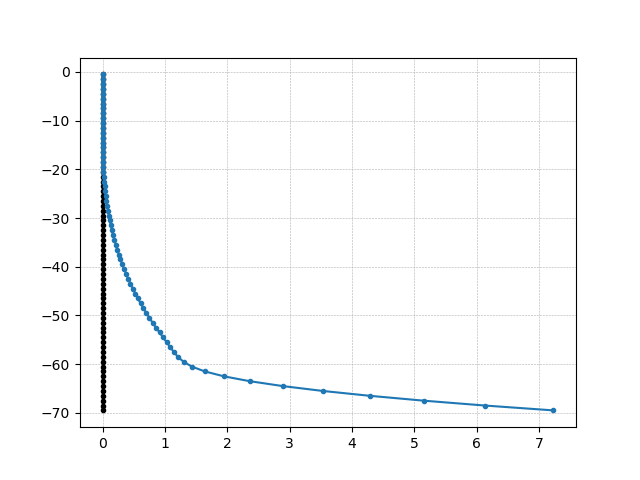

In [116]:
plt.close()
plt.figure()

# plt.plot(b, zC, '.-k')
# plt.plot(pe, zC, '.-')
plt.plot(pe_mixed - pe, zC, '.-')
plt.grid(ls='--', lw=0.4);
# plt.axhline(-mld1, ls='--', c='C0')
# plt.axhline(-mld2, ls='--', c='C1')
# plt.axhline(-mld3, ls='--', c='C2')
# plt.ylim(-70, 0);

### Mixed layer depth

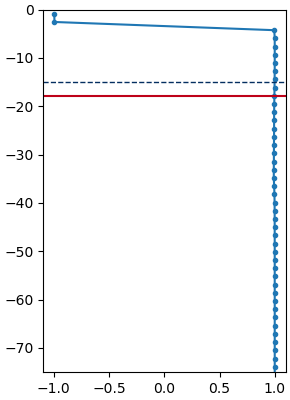

In [32]:
plt.close()
plt.figure(figsize=(2.9,4), constrained_layout=True)

itime = 48 - 1
y0 = 1200
x0 = -2400

plt.plot(dsl.nGbz.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), dsl.zC, '.-');

# plt.plot(-dsl.wc.isel(time=itime).sel(xC=x0, method='nearest').mean('yC') / \
#          dsl.dcdz.isel(time=itime).sel(xC=x0, method='nearest').mean('yC') / ((4.8e-10*30)**(1/3)*30), dsl.zC)


# plt.plot(dsl.b.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), ds.zC);
# plt.plot(dsl.c.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), ds.zC);
# plt.plot(dsl.c.isel(time=itime).sel(yC=y0, xC=x0+200, method='nearest'), ds.zC);

# plt.plot(dsl.u.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), ds.zC);
# plt.plot(dsl.v.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), ds.zC);

# plt.plot(ds.w.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), ds.zC);
# plt.plot(dsl.w.isel(time=itime).sel(yC=y0, xC=x0, method='nearest'), ds.zC);

plt.axhline(-dsf.mld.isel(time=itime).sel(xC=x0, method='nearest').mean('yC'), c='xkcd:scarlet')
plt.axhline(-dsf.bld.isel(time=itime).sel(xC=x0, method='nearest').mean('yC'), c='xkcd:marine', ls='--', lw=1)

plt.ylim(-75, 0);

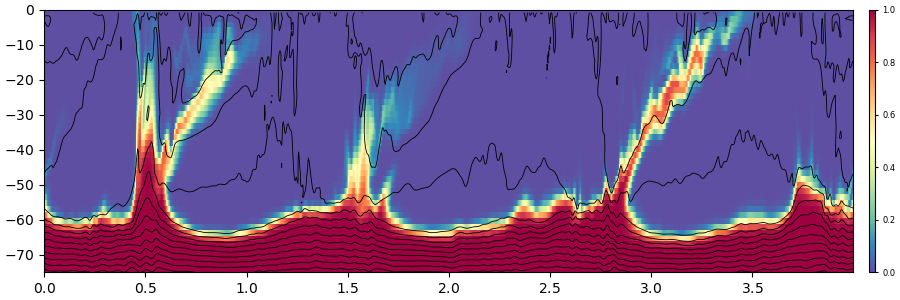

In [61]:
plt.close()
plt.figure(figsize=(9,3), constrained_layout=True)

itime = 24
x0 = -3300
pcm,_ = pcolor_limits(ds.c7.isel(time=itime).sel(xC=x0, method='nearest'), plt.gca(), cmap='Spectral_r', clim=[0,1])
# pcm,_ = pcolor_center(ds.w.isel(time=itime).sel(xC=x0, method='nearest'), plt.gca(), cmap='w')
# pcm,_ = pcolor_center(dsl.wc.isel(time=itime).sel(xC=x0, method='nearest'), plt.gca(), cmap='cp')
# pcm,_ = pcolor_center((dsl.w*dsl.c).isel(time=itime).sel(xC=x0, method='nearest'), plt.gca(), cmap='cp')

# plt.plot(dsl.yC/1e3, -dsl.mld.sel(xC=x0, method='nearest'), 'xkcd:scarlet')
# plt.plot(dsl.yC/1e3, -dsl.bld.sel(xC=x0, method='nearest'), 'C2')
config_colorbar(pcm, plt.gca())

plt.contour(ds.yC/1e3, ds.zC, ds.b.isel(time=itime).sel(xC=x0, method='nearest'), blines_upper, colors='k', linewidths=0.6)
plt.ylim(-75, 0);
# plt.xlim(-3.2, -0.8);

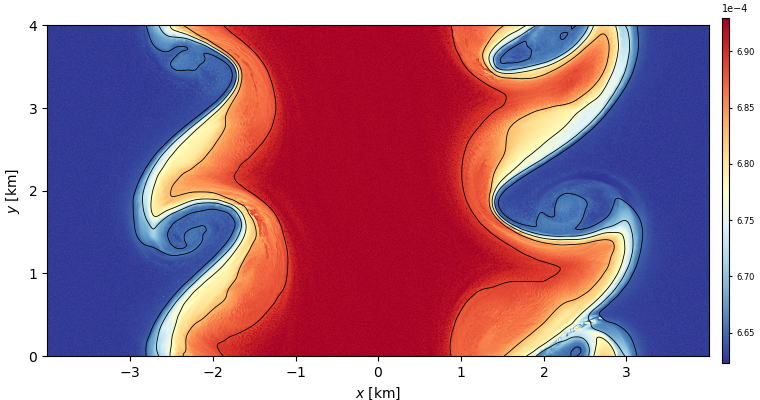

In [58]:
plt.close()
plt.figure(figsize=(7.6,4), constrained_layout=True)
# plt.figure(figsize=(3.1,4), constrained_layout=True)

itime = 36 - 1
depth = 20

# pcm,_ = pcolor_limits(dsl.mld.isel(time=itime), cmap='viridis_r')#, clim=[10, 30])
# pcm,_ = pcolor_center(dsl.mld.isel(time=itime) - dsf.bld.isel(time=itime), cmap='RdBu_r')

# pcm,_ = pcolor_center(dsl.mld.isel(time=itime)-dsl.mld.isel(time=itime,xC=0).mean()+1, cmap='RdBu_r')#, clim=[10, 30])

# pcm,_ = pcolor_center(dsl.nFFcz.isel(time=itime).sel(zC=-depth, method='nearest'), cmap=plt.get_cmap('flux', 11), smag=1)
# pcm,_ = pcolor_limits(np.abs(dsl.nFFcz.isel(time=itime).sel(zC=-depth, method='nearest')), cmap=plt.get_cmap('YlGnBu', 10), clim=[0, 1])
# pcm,_ = pcolor_center(dsl.nSFcz.isel(time=itime).sel(zC=-depth, method='nearest'), cmap=plt.get_cmap('flux', 11), smag=1)
# pcm,_ = pcolor_limits(np.abs(dsl.nSFcz.isel(time=itime).sel(zC=-depth, method='nearest').where(np.abs(dsl.w*dsl.c).isel(time=itime).sel(zC=-depth, method='nearest') >= 1e-4)),
#                       cmap=plt.get_cmap('cmo.tempo', 10), clim=[0, 1])

# pcm,_ = pcolor_limits(ds.c.isel(time=itime).sel(zC=-depth, method='nearest'), cmap='c', clim=[0,1])
pcm,_ = pcolor_limits(ds.b.isel(time=itime).sel(zC=-depth, method='nearest'), cmap='RdYlBu_r')
# pcm,_ = pcolor_limits(ds.cflux0.isel(time=itime), cmap='Blues_r')
# pcm,_ = pcolor_center(dsl.wc.isel(time=itime).sel(zC=-depth, method='nearest'), cmap=plt.get_cmap('cp', 11), cupr=2)
# pcm,_ = pcolor_center(interp_to_zi(dsl.wc.isel(time=itime), -dsf.mld.isel(time=itime)), cmap='cp')
# pcm,_ = pcolor_center((dsl.w*dsl.c).isel(time=itime).sel(zC=-depth, method='nearest'), cmap=plt.get_cmap('cp', 11), cupr=2)
# pcm,_ = pcolor_center(interp_to_zi((dsl.w*dsl.c).isel(time=itime), -dsf.mld.isel(time=itime)), cmap='cp')

config_colorbar(pcm)#, sci_notation=False)

# plt.contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).where(dsl.zC >= -60).mean('zC'), blines_upper, colors='k', linewidths=0.6)
plt.contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).sel(zC=-depth, method='nearest'), blines_upper, colors='k', linewidths=0.6)
# plt.contour(dsl.xC/1e3, dsl.yC/1e3, dsl.mask_fz.isel(time=itime), [0.5, 1.5], colors='xkcd:mauve')

# idx1, idx2 = np.argwhere(np.diff(dsl.mask_fz.isel(time=itime, xC=slice(None,1000)), axis=-1).min(axis=0) < 0)[[0, -1]]
# plt.axvline(dsl.xC[idx1+1]/1e3, c='gray')
# plt.axvline(dsl.xC[idx2]/1e3, c='gray')

# idx3, idx4 = np.argwhere(np.diff(dsl.mask_fz.isel(time=itime, xC=slice(1000,None)), axis=-1).max(axis=0) > 0)[[0, -1]]
# plt.axvline(dsl.xC[idx3+1000+1]/1e3, c='gray')
# plt.axvline(dsl.xC[idx4+1000]/1e3, c='gray')

plt.gca().set_yticks(np.linspace(0,4,5))
plt.gca().set_aspect('equal')
plt.gca().set_xlabel(r'$x$ [km]')
plt.gca().set_ylabel(r'$y$ [km]');

# plt.xlim(-3.3, -0.7);

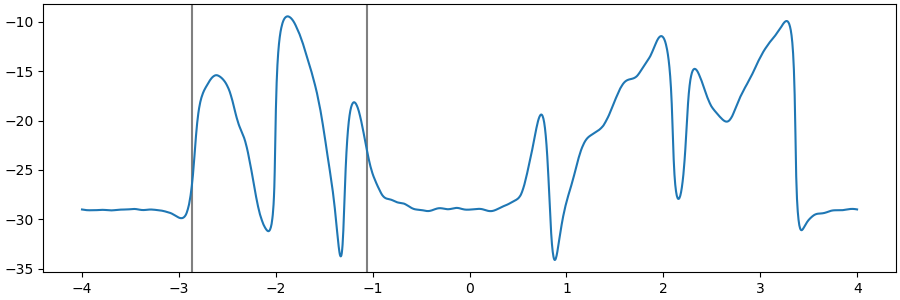

In [69]:
plt.close()
plt.figure(figsize=(9,3), constrained_layout=True)

idx1, idx2 = np.argwhere(np.diff(dsl.mask_fz.isel(time=itime, xC=slice(None,1000)).sel(yC=3617, method='nearest'), axis=-1) < 0)[[0, -1]]
plt.axvline(ds.xC[idx1+1]/1e3, c='gray')
plt.axvline(ds.xC[idx2]/1e3, c='gray')

plt.plot(ds.xC/1e3, -dsl.mld.isel(time=itime).sel(yC=3617, method='nearest'));

In [ ]:
dsl.mld.where(dsl.mask_fz.isel(time=itime)==0).mean().load()

# mask_fz_rect = ((dsl.xC >= dsl.xC[idx1+1][0]) & (dsl.xC < dsl.xC[idx2][0])) | ((dsl.xC >= dsl.xC[idx3+1][0]) & (dsl.xC < dsl.xC[idx4][0]))
# dsl.mld.where(mask_fz_rect).mean().load()

### Vertically integrated fine-scale kinetic energy budget terms

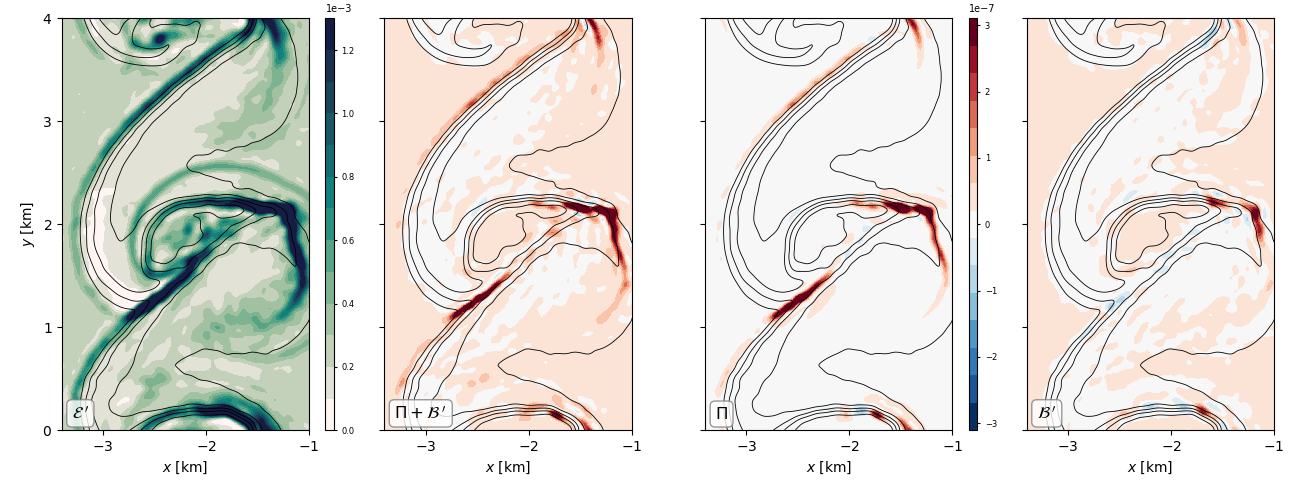

In [153]:
plt.close()
_,ax = plt.subplots(1,4, figsize=(13, 4.8), constrained_layout=True, sharex=True, sharey=True)

itime = 48 - 1
pcm0,_ = pcolor_limits(dsf.Ifske.isel(time=itime), ax[0], cmap=plt.get_cmap('cmo.tempo',13), clim=[0, 13e-4])
_,mag1 = pcolor_center((dsf.ISP + dsf.IVBP).isel(time=itime), ax[1], cmap=plt.get_cmap('RdBu_r',15), cupr=2)
pcm2,_ = pcolor_center(dsf.IHSP.isel(time=itime), ax[2], cmap=plt.get_cmap('RdBu_r',15), smag=mag1)
_,_    = pcolor_center(dsf.IVBP.isel(time=itime), ax[3], cmap=plt.get_cmap('RdBu_r',15), smag=mag1)
# pcm2,_ = pcolor_center(dsf.IHSP.isel(time=itime), ax[2], cmap=plt.get_cmap('RdBu_r',15), smag=mag1)
# _,_    = pcolor_center(dsf.IVSP_uv.isel(time=itime), ax[3], cmap=plt.get_cmap('RdBu_r',15), smag=mag1)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm2, ax[2])

depth = 8
txt_strs = [r"$\mathcal{E}\,'$", r"$\Pi + \mathcal{B}\,'$", r'$\Pi$', r"$\mathcal{B}\,'$"]
# txt_strs = [r"$\mathcal{E}\,'$", r"$\Pi + \mathcal{B}\,'$", r'$\Pi_h$', r'$\Pi_v$']

for j in range(4):
    # ax[j].contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).where(dsl.zC >= -60).mean('zC'), blines_upper, colors='k', linewidths=0.6)
    ax[j].contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).sel(zC=-depth, method='nearest'), blines_upper, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3.4, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

In [ ]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(6, 5), constrained_layout=True, sharex=True, sharey=True)

itime = 36

pcm0,_ = pcolor_center(dsf.IVBP.isel(time=itime), ax[0], cmap=plt.get_cmap('RdBu_r',15))
pcm1,_ = pcolor_center(((dsl.w*dsl.b).transpose(..., 'zC')*dzF).isel(time=itime).sum('zC'), ax[1], cmap=plt.get_cmap('RdBu_r',15))
config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])

txt_strs = [r"$\mathcal{B}\,'$", r"$\overline{\mathcal{B}}$"]
for j in range(2):
    ax[j].contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).where(dsl.zC >= -60).mean('zC'), blines_upper, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

### Horizontal slices of vertical fluxes

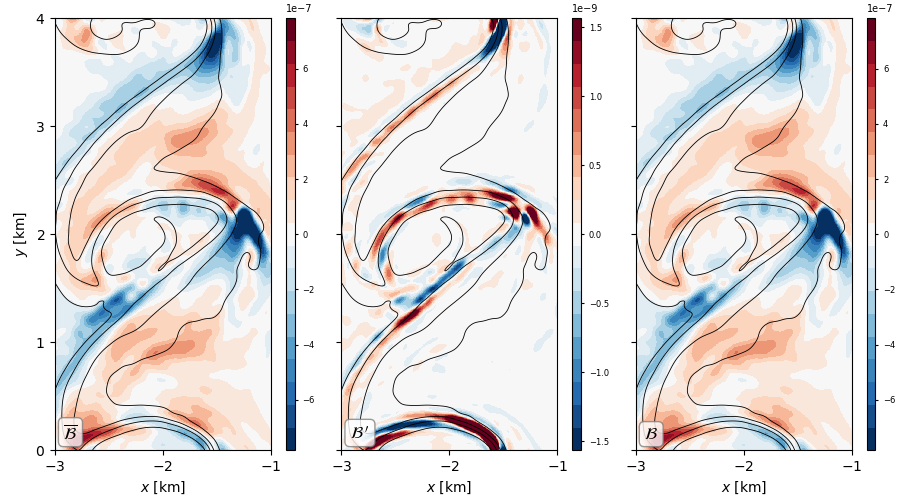

In [35]:
plt.close()
_,ax = plt.subplots(1,3, figsize=(9, 5), constrained_layout=True, sharex=True, sharey=True)

itime = 36
depth = 20

pcm0,mag0 = pcolor_center((dsl.w*dsl.b).isel(time=itime).sel(zC=-depth, method='nearest'), ax[0], cmap=plt.get_cmap('RdBu_r',19), cupr=1.5)
pcm1,_    = pcolor_center(dsl.wb.isel(time=itime).sel(zC=-depth, method='nearest'), ax[1], cmap=plt.get_cmap('RdBu_r',19), smag=mag0/500)
pcm2,_    = pcolor_center(filter_taper.apply((ds.w*ds.b).isel(time=itime).sel(zC=-depth, method='nearest'),  dims=['yC', 'xC']), 
                          ax[2], cmap=plt.get_cmap('RdBu_r',19), smag=mag0)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])
config_colorbar(pcm2, ax[2])

txt_strs = [r"$\overline{\mathcal{B}}$", r"$\mathcal{B}\,'$", r"$\mathcal{B}$"]
for j in range(3):
    ax[j].contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).sel(zC=-depth, method='nearest'), blines_upper, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

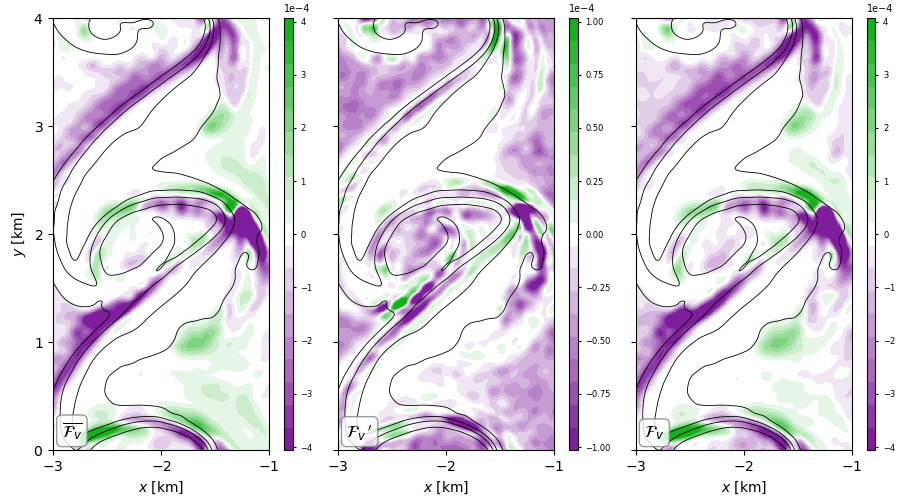

In [36]:
plt.close()
_,ax = plt.subplots(1,3, figsize=(9, 5), constrained_layout=True, sharex=True, sharey=True)

itime = -1
depth = 20

pcm0,mag0 = pcolor_center((dsl.w*dsl.c).isel(time=itime).sel(zC=-depth, method='nearest'), ax[0], cmap=plt.get_cmap('cp',19), cupr=1)
pcm1,_    = pcolor_center(dsl.wc.isel(time=itime).sel(zC=-depth, method='nearest'), ax[1], cmap=plt.get_cmap('cp',19), smag=mag0/4)
pcm2,_    = pcolor_center(filter_taper.apply((ds.w*ds.c).isel(time=itime).sel(zC=-depth, method='nearest'), dims=['yC', 'xC']), 
                          ax[2], cmap=plt.get_cmap('cp',19), smag=mag0)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])
config_colorbar(pcm2, ax[2])

txt_strs = [r"$\overline{\mathcal{F}_v}$", r"$\mathcal{F}_v\,'$", r"$\mathcal{F}_v$"]
for j in range(3):
    ax[j].contour(dsl.xC/1e3, dsl.yC/1e3, dsl.b.isel(time=itime).sel(zC=-depth, method='nearest'), blines_upper, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

### Vertical fluxes decomposed to diapycnal and isopycnal parts

#### 1. Submesoscale flux

In [31]:
use_filtered_ds = True
use_c_gradient  = False

ds_parent = dsl if use_filtered_ds else ds
gtype     = 'c' if use_c_gradient else 'b'
varsg     = ['nG'+gtype+i for i in ['x', 'y', 'z']]
nGx, nGy, nGz = ds_parent[varsg[0]], ds_parent[varsg[1]], ds_parent[varsg[2]]

In [32]:
dsl['SFc_dia'] = dsl.u_c * nGx + dsl.v_c * nGy + dsl.w_c * nGz
dsl['w_c_dia'] = (dsl.SFc_dia * nGz)#.where(dsl.mGb >= 1e-8)
dsl['w_c_iso'] = dsl.w_c - dsl.w_c_dia

In [ ]:
plt.close()
_,ax = plt.subplots(1,4, figsize=(12, 5), constrained_layout=True, sharex=True, sharey=True)

itime = 48 - 1
depth = 30

pcm0,mag0 = pcolor_center(dsl.w_c.isel(time=itime).sel(zC=-depth, method='nearest'), ax[0], cmap=plt.get_cmap('cp',19), cupr=2.5)
pcm1,_    = pcolor_center(dsl.w_c_dia.isel(time=itime).sel(zC=-depth, method='nearest'), ax[1], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm2,_    = pcolor_center(dsl.w_c_iso.isel(time=itime).sel(zC=-depth, method='nearest'), ax[2], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm3,_    = pcolor_center((dsl.w_c_dia/dsl.w_c.where(np.abs(dsl.w_c) >= mag0/10)).isel(time=itime).sel(zC=-depth, method='nearest'), 
                          ax[3], cmap=plt.get_cmap('RdBu_r',10), smag=1)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])
config_colorbar(pcm2, ax[2])
config_colorbar(pcm3, ax[3], extend='both')

txt_strs = [r"Submeso $\mathcal{F}_v$", r"Submeso $\mathcal{F}_v^{\,dia}$", r"Submeso $\mathcal{F}_v^{\,iso}$", "Dia. ratio $r$"]
for j in range(4):
    ax[j].contour(ds_parent.xC/1e3, ds_parent.yC/1e3, ds_parent.b.isel(time=itime).sel(zC=-depth, method='nearest'),
                  blines_upper, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12,# fontweight='bold',
               bbox=dict(facecolor='w', edgecolor='gray', alpha=0.7, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

In [37]:
itime = 48 - 1
zi_to_mld = 1

u_c_mld = interp_to_zi((dsl.u_c).isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
v_c_mld = interp_to_zi((dsl.v_c).isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
w_c_mld = interp_to_zi((dsl.w_c).isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)

nGx_mld = interp_to_zi(nGx.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
nGy_mld = interp_to_zi(nGy.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
nGz_mld = interp_to_zi(nGz.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)

SFc_mld_dia = u_c_mld * nGx_mld + v_c_mld * nGy_mld + w_c_mld * nGz_mld
w_c_mld_dia = SFc_mld_dia * nGz_mld
w_c_mld_iso = w_c_mld - w_c_mld_dia

/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


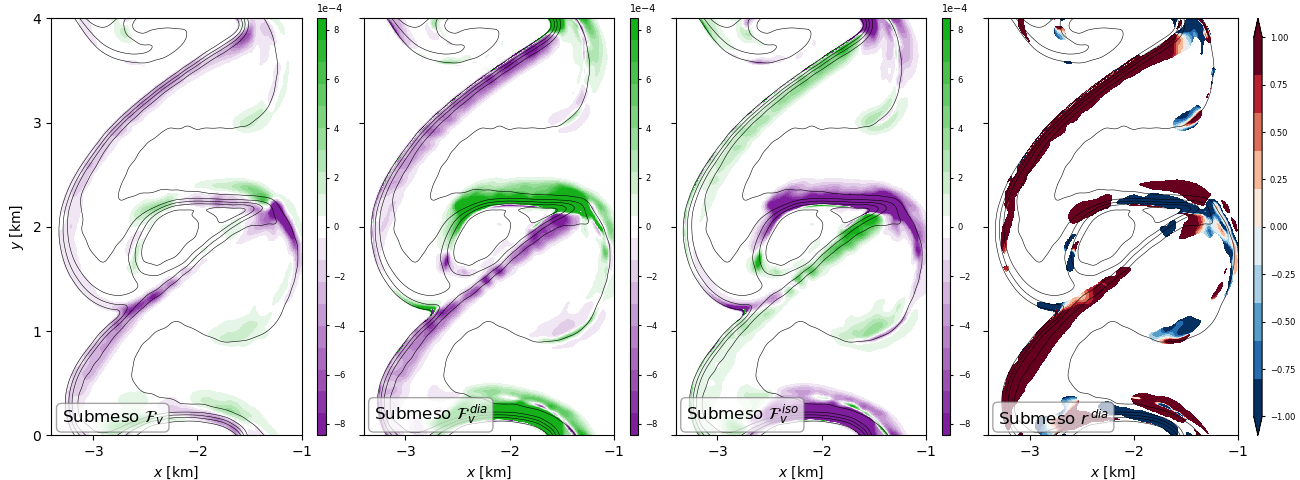

In [38]:
plt.close()
_,ax = plt.subplots(1,4, figsize=(13, 4.8), constrained_layout=True, sharex=True, sharey=True)

pcm0,mag0 = pcolor_center(w_c_mld, ax[0], cmap=plt.get_cmap('cp',19), cupr=2)
pcm1,_    = pcolor_center(w_c_mld_dia, ax[1], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm2,_    = pcolor_center(w_c_mld_iso, ax[2], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm3,_    = pcolor_center(w_c_mld_dia/w_c_mld.where(np.abs(w_c_mld) >= mag0/10), 
                          ax[3], cmap=plt.get_cmap('RdBu_r',10), smag=1)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])
config_colorbar(pcm2, ax[2])
config_colorbar(pcm3, ax[3], extend='both')

txt_strs = [r"Submeso $\mathcal{F}_v$", r"Submeso $\mathcal{F}_v^{\,dia}$", r"Submeso $\mathcal{F}_v^{\,iso}$", r"Submeso $r^{\,dia}$"]
for j in range(4):
    # ax[j].contour(ds_parent.xC/1e3, ds_parent.yC/1e3, ds_parent.b.isel(time=itime).where(dsl.zC >= -60).mean('zC'),
    #               blines_upper, colors='k', linewidths=0.4)
    ax[j].contour(ds_parent.xC/1e3, ds_parent.yC/1e3, ds_parent.b.isel(time=itime, zC=-1),
                  blines_upper, colors='k', linewidths=0.4)
    # ax[j].contour(ds.xC/1e3, ds.yC/1e3, ds.b.isel(time=itime, zC=-1),
    #               blines_upper, colors='k', linewidths=0.4)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12,# fontweight='bold',
               bbox=dict(facecolor='w', edgecolor='gray', alpha=0.7, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3.4, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

#### 2. Finescale flux

In [18]:
use_filtered_ds = True
use_c_gradient  = False

ds_parent = dsl if use_filtered_ds else ds
gtype     = 'c' if use_c_gradient else 'b'
varsg     = ['nG'+gtype+i for i in ['x', 'y', 'z']]
nGx, nGy, nGz = ds_parent[varsg[0]], ds_parent[varsg[1]], ds_parent[varsg[2]]

In [19]:
dsl['FFc_dia'] = dsl.uc * nGx + dsl.vc * nGy + dsl.wc * nGz
dsl['wc_dia']  = (dsl.FFc_dia * nGz)#.where(dsl.mGb >= 1e-8)
dsl['wc_iso']  = dsl.wc - dsl.wc_dia

In [ ]:
plt.close()
_,ax = plt.subplots(1,4, figsize=(13, 4.8), constrained_layout=True, sharex=True, sharey=True)

itime = 48 - 1
depth = 15

pcm0,mag0 = pcolor_center(dsl.wc.isel(time=itime).sel(zC=-depth, method='nearest'), ax[0], cmap=plt.get_cmap('cp',19), cupr=2)
pcm1,_    = pcolor_center(dsl.wc_dia.isel(time=itime).sel(zC=-depth, method='nearest'), ax[1], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm2,_    = pcolor_center(dsl.wc_iso.isel(time=itime).sel(zC=-depth, method='nearest'), ax[2], cmap=plt.get_cmap('cp',19), smag=mag0)
# pcm3,_    = pcolor_center((dsl.wc_dia/dsl.wc.where(np.abs(dsl.wc) >= mag0/10)).isel(time=itime).sel(zC=-depth, method='nearest'), 
#                           ax[3], cmap=plt.get_cmap('RdBu_r',10), smag=1)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])
config_colorbar(pcm2, ax[2])
config_colorbar(pcm3, ax[3], extend='both')

txt_strs = [r"Fine $\mathcal{F}_v$", r"Fine $\mathcal{F}_v^{\,dia}$", r"Fine $\mathcal{F}_v^{\,iso}$", r"Fine $r^{\,dia}$"]
for j in range(4):
    ax[j].contour(ds_parent.xC/1e3, ds_parent.yC/1e3, ds_parent.b.isel(time=itime).sel(zC=-depth, method='nearest'),
                  blines_upper, colors='k', linewidths=0.4)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12,# fontweight='bold',
               bbox=dict(facecolor='w', edgecolor='gray', alpha=0.7, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3.4, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

In [18]:
itime = 48 - 1
zi_to_mld = 1

uc_mld = interp_to_zi(dsl.uc.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
vc_mld = interp_to_zi(dsl.vc.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
wc_mld = interp_to_zi(dsl.wc.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)

nGx_mld = interp_to_zi(nGx.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
nGy_mld = interp_to_zi(nGy.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)
nGz_mld = interp_to_zi(nGz.isel(time=itime), -dsf.mld.isel(time=itime)*zi_to_mld)

FFc_mld_dia = uc_mld * nGx_mld + vc_mld * nGy_mld + wc_mld * nGz_mld
wc_mld_dia  = FFc_mld_dia * nGz_mld
wc_mld_iso  = wc_mld - wc_mld_dia

/glade/work/zhihuaz/conda-envs/trace-seas/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


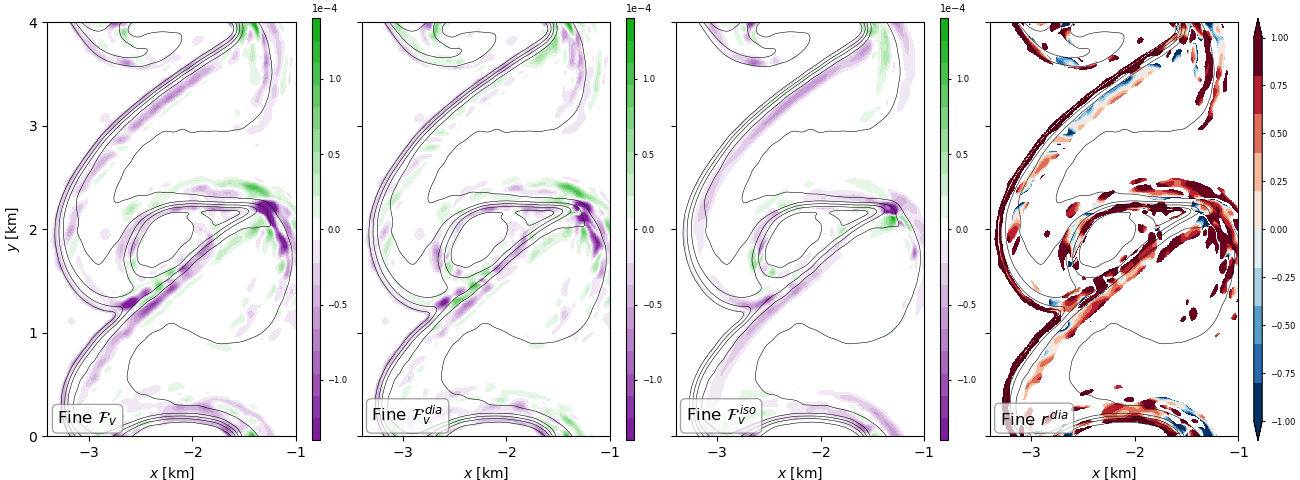

In [19]:
plt.close()
_,ax = plt.subplots(1,4, figsize=(13, 4.8), constrained_layout=True, sharex=True, sharey=True)

pcm0,mag0 = pcolor_center(wc_mld, ax[0], cmap=plt.get_cmap('cp',19), cupr=2)
pcm1,_    = pcolor_center(wc_mld_dia, ax[1], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm2,_    = pcolor_center(wc_mld_iso, ax[2], cmap=plt.get_cmap('cp',19), smag=mag0)
pcm3,_    = pcolor_center(wc_mld_dia/wc_mld.where(np.abs(wc_mld) >= mag0/10), 
                          ax[3], cmap=plt.get_cmap('RdBu_r',10), smag=1)

config_colorbar(pcm0, ax[0])
config_colorbar(pcm1, ax[1])
config_colorbar(pcm2, ax[2])
config_colorbar(pcm3, ax[3], extend='both')

txt_strs = [r"Fine $\mathcal{F}_v$", r"Fine $\mathcal{F}_v^{\,dia}$", r"Fine $\mathcal{F}_v^{\,iso}$", r"Fine $r^{\,dia}$"]
for j in range(4):
    # ax[j].contour(ds_parent.xC/1e3, ds_parent.yC/1e3, ds_parent.b.isel(time=itime).where(dsl.zC >= -60).mean('zC'),
    #               blines_upper, colors='k', linewidths=0.4)
    ax[j].contour(ds_parent.xC/1e3, ds_parent.yC/1e3, ds_parent.b.isel(time=itime, zC=-1),
                  blines_upper, colors='k', linewidths=0.4)
    # ax[j].contour(ds.xC/1e3, ds.yC/1e3, ds.b.isel(time=itime, zC=-1),
    #               blines_upper, colors='k', linewidths=0.4)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12,# fontweight='bold',
               bbox=dict(facecolor='w', edgecolor='gray', alpha=0.7, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3.4, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

### 3D subset

In [94]:
from viztool import plot_box_frame

def set_ax3d_ticks(ax, length=2, labelsize=6):
    ax.locator_params(axis='x', nbins=4)
    ax.locator_params(axis='y', nbins=4)
    ax.locator_params(axis='z', nbins=4)
    ax.tick_params(axis='both', labelsize=labelsize, length=length)
    ax.tick_params(axis='z',    labelsize=labelsize, length=length)

def plot_xyz3d(ax, xyplane, xzplane, yzplane, **kwargs):
    aspect_xy = kwargs.pop('aspect_xy')
    xlim      = kwargs.pop('xlim')
    ylim      = kwargs.pop('ylim')
    zlim      = kwargs.pop('zlim')
    azim      = kwargs.pop('azim')
    elev      = kwargs.pop('elev')
    blines    = kwargs.pop('blines')
    var       = kwargs.pop('var')
    add_cbar   = kwargs.pop('add_cbar', False)
    sci_cbar   = kwargs.pop('sci_cbar', False)
    nbins_cbar = kwargs.pop('nbins_cbar', None)

    xvar, yvar, zvar = sorted(xyplane[var].dims)
    xb, yb, zb = sorted(xyplane.b.dims)
    hvar = 'mld' if 'mld' in list(xyplane.data_vars.keys()) else 'bld'

    xyplane = xyplane.isel(zC=0).transpose('yC', 'xC')
    xzplane = xzplane.isel(yC=0).transpose('zC', 'xC')
    yzplane = yzplane.isel(xC=0).transpose('zC', 'yC')

    bkw_light = dict(levels=blines, linewidths=0.35, colors='xkcd:almost black')
    edges_kw  = dict(color='xkcd:dark grey', linewidth=1, zorder=2)

    ax.contourf(xyplane[xvar], xyplane[yvar], xyplane[var], zdir='z', offset=xyplane[zvar], **kwargs)
    ax.contour(xyplane[xb], xyplane[yb], xyplane.b, zdir='z', offset=xyplane[zb], **bkw_light)
    
    X, Z = np.meshgrid(xzplane[xvar], xzplane[zvar])
    im = ax.contourf(X, xzplane[var], Z, zdir='y', offset=xzplane[yvar], **kwargs)
    X, Z = np.meshgrid(xzplane[xb], xzplane[zb])
    ax.plot(xzplane[xb], np.ones_like(xzplane[xb])*xzplane[yb].data, -xzplane[hvar].where(-xzplane[hvar] < zlim[-1]), c='xkcd:aqua blue')
    ax.contour(X, xzplane.b, Z, zdir='y', offset=xzplane[yb], **bkw_light)
    
    Y, Z = np.meshgrid(yzplane[yvar], yzplane[zvar])
    ax.contourf(yzplane[var], Y, Z, zdir='x', offset=yzplane[xvar], **kwargs)
    Y, Z = np.meshgrid(yzplane[yb], yzplane[zb])
    ax.contour(yzplane.b, Y, Z, zdir='x', offset=yzplane[xb], **bkw_light)
    ax.plot(np.ones_like(yzplane[yb])*yzplane[xb].data, yzplane[yb], -yzplane[hvar].where(-yzplane[hvar] < zlim[-1]), c='xkcd:aqua blue')

    # ax.axis('off')
    set_ax3d_ticks(ax, length=1, labelsize=6)
    ax.set(xlim=xlim, ylim=ylim, zlim=zlim)
    ax.view_init(elev=elev, azim=azim)
    plot_box_frame(ax, xlim, ylim, zlim, azim=azim, **edges_kw)
    ax.set_box_aspect((aspect_xy[0], aspect_xy[1], 1), zoom=0.95)

    if add_cbar:
        config_colorbar(im, ax, sci_notation=sci_cbar, shrink=0.5, nbins=nbins_cbar)
    return im


def plot_surf3d(ax, xyplane, xzplane, yzplane, **kwargs):
    aspect_xy = kwargs.pop('aspect_xy')
    xlim      = kwargs.pop('xlim')
    ylim      = kwargs.pop('ylim')
    zlim      = kwargs.pop('zlim')
    clim      = kwargs.pop('clim')
    azim      = kwargs.pop('azim')
    elev      = kwargs.pop('elev')
    blines    = kwargs.pop('blines')
    var       = kwargs.pop('var')
    cmap      = kwargs.pop('cmap')
    add_cbar   = kwargs.pop('add_cbar')
    sci_cbar   = kwargs.pop('sci_cbar')
    nbins_cbar = kwargs.pop('nbins_cbar', None)

    xvar, yvar, zvar = sorted(xyplane[var].dims)
    xb, yb, zb = sorted(xyplane.b.dims)
    hvar = 'mld' if 'mld' in list(xyplane.data_vars.keys()) else 'bld'

    xyplane = xyplane.isel(zC=0).transpose('yC', 'xC')
    xzplane = xzplane.isel(yC=0).transpose('zC', 'xC')
    yzplane = yzplane.isel(xC=0).transpose('zC', 'yC')

    bkw_light = dict(levels=blines, linewidths=0.35, colors='xkcd:almost black')
    edges_kw  = dict(color='xkcd:navy', linewidth=1, zorder=2)

    X, Y = np.meshgrid(xyplane[xvar], xyplane[yvar])
    norm = Normalize(clim[0], clim[1])
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    fcolors = m.to_rgba(xyplane[var])
    ax.plot_surface(X, Y, -xyplane[hvar], facecolors=fcolors, rstride=1, cstride=1, cmap=cmap)

    X, Z = np.meshgrid(xzplane[xvar], xzplane[zvar])
    im = ax.contourf(X, xzplane[var].where(xzplane[zvar] < -xzplane[hvar]), Z, zdir='y', offset=xzplane[yvar], cmap=cmap, **kwargs)
    X, Z = np.meshgrid(xzplane[xb], xzplane[zb])
    ax.plot(xzplane[xb], np.ones_like(xzplane[xb])*xzplane[yb].data, -xzplane[hvar], c='xkcd:aqua blue')
    ax.contour(X, xzplane.b.where(xzplane[zb] < -xzplane[hvar]), Z, zdir='y', offset=xzplane[yb], **bkw_light)
    
    Y, Z = np.meshgrid(yzplane[yvar], yzplane[zvar])
    ax.contourf(yzplane[var].where(yzplane[zvar] < -yzplane[hvar]), Y, Z, zdir='x', offset=yzplane[xvar], cmap=cmap, **kwargs)
    Y, Z = np.meshgrid(yzplane[yb], yzplane[zb])
    ax.contour(yzplane.b.where(yzplane[zb] < -yzplane[hvar]), Y, Z, zdir='x', offset=yzplane[xb], **bkw_light)
    ax.plot(np.ones_like(yzplane[yb])*yzplane[xb].data, yzplane[yb], -yzplane[hvar], c='xkcd:aqua blue')

    # ax.axis('off')
    set_ax3d_ticks(ax, length=1, labelsize=6)
    ax.set(xlim=xlim, ylim=ylim, zlim=zlim)
    ax.view_init(elev=elev, azim=azim)
    # plot_box_frame(ax, xlim, ylim, zlim, azim=azim, **edges_kw)
    ax.set_box_aspect((aspect_xy[0], aspect_xy[1], 1), zoom=0.95)

    # if add_cbar:
    #     config_colorbar(im, ax, sci_notation=sci_cbar, shrink=0.5, nbins=nbins_cbar)
    # return im

In [ ]:
itime  = 36 - 1
cupr   = 1.08
# x1, x2 = -3250, -1420
# y1, y2 =  240,  2440

x1, x2 = -3250, -1620
y1, y2 =  0,  4000
z1, z2 =   -70, -8
box3d  = dict(xC=slice(x1, x2), yC=slice(y1, y2), zC=slice(z1, z2))

var_to_plot = 'c'
subset   = xr.merge([ds.b, dsf.mld, ds[var_to_plot]]).isel(time=itime).sel(box3d)
xy_plane = subset.isel(zC=[-1])
xz_plane = subset.isel(yC=[0])
yz_plane = subset.isel(xC=[-1])

subset_xlim = xz_plane.xC.min().item(), xz_plane.xC.max().item()
subset_ylim = yz_plane.yC.min().item(), yz_plane.yC.max().item()
subset_zlim = yz_plane.zC.min().item(), yz_plane.zC.max().item()

Ly_to_Lx = (subset_ylim[1] - subset_ylim[0]) / (subset_xlim[1] - subset_xlim[0])
var_mag = np.max([np.abs(xy_plane[var_to_plot]).quantile(0.99),
                  np.abs(xz_plane[var_to_plot]).quantile(0.99),
                  np.abs(yz_plane[var_to_plot]).quantile(0.99)]).item()*cupr
# var_mag = 2e-4
# var_mag = 1
# var_mag = 5.82e-9


# var_max = np.max([xy_plane[var_to_plot].quantile(0.99),
#                   xz_plane[var_to_plot].quantile(0.99),
#                   yz_plane[var_to_plot].quantile(0.99)]).item()

# var_min = np.min([xy_plane[var_to_plot].quantile(0.01),
#                   xz_plane[var_to_plot].quantile(0.01),
#                   yz_plane[var_to_plot].quantile(0.01)]).item()*cupr

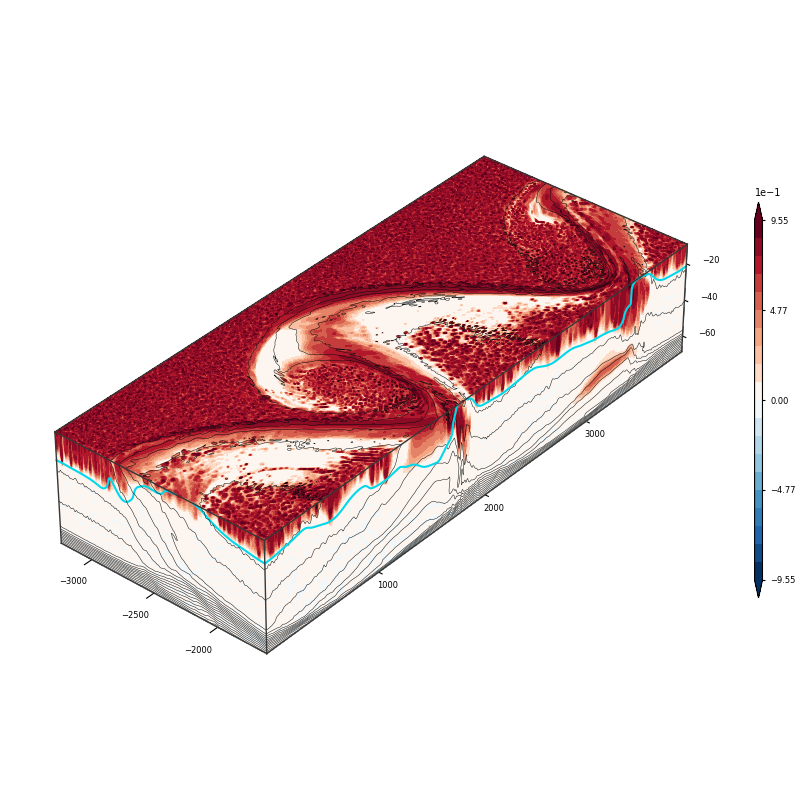

In [203]:
plt.close()
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

xyz3d_kwargs = dict(var=var_to_plot,
                    blines=blines_upper,
                    add_cbar=True,
                    sci_cbar=True,
                    nbins_cbar=4,
                    # cmap=plt.get_cmap('cp_ds', 41),
                    # levels=np.linspace(-var_mag, var_mag, 41),

                    cmap=plt.get_cmap('Spectral_r', 21),
                    levels=np.linspace(0, 1, 21),
                    
                    # cmap=plt.get_cmap('RdYlBu_r', 21),
                    # levels=np.linspace(var_min, var_max, 21),
                    
                    # cmap=plt.get_cmap('RdBu_r_ds', 21),
                    # levels=np.linspace(-var_mag, var_mag, 21),

                    # cmap=plt.get_cmap('cmo.tempo',10),
                    # levels=np.linspace(0, var_mag, 11),
                    
                    extend='both',
                    aspect_xy=[2, 2*Ly_to_Lx],
                    xlim=subset_xlim, ylim=subset_ylim, zlim=subset_zlim,
                    azim=-50,
                    elev=35)

plot_xyz3d(ax, xy_plane, xz_plane, yz_plane, **xyz3d_kwargs);

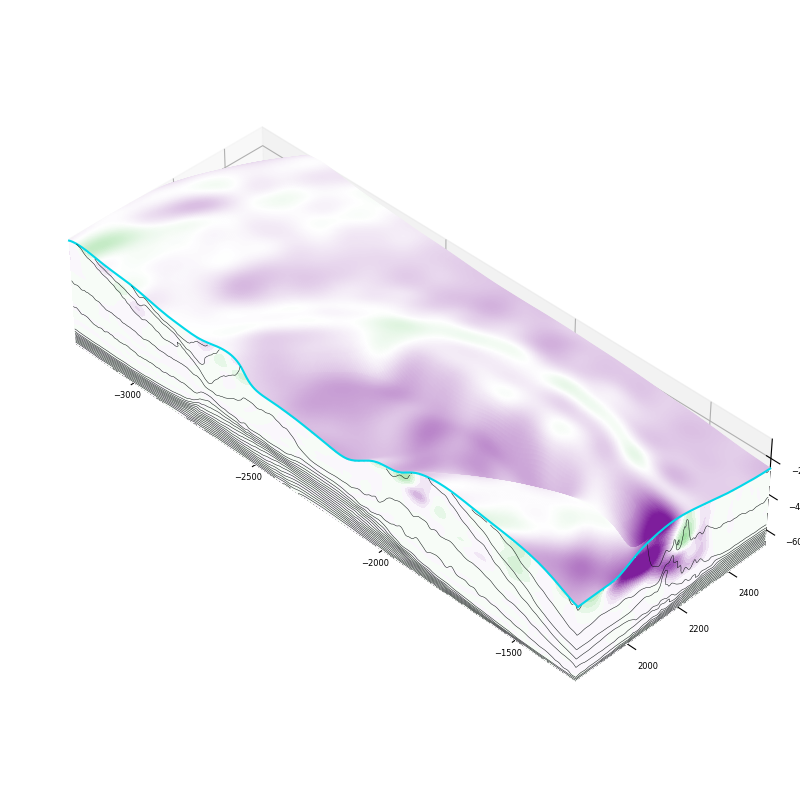

In [51]:
plt.close()
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax  = fig.add_subplot(111, projection='3d', computed_zorder=False)

surf3d_kwargs = dict(var=var_to_plot,
                    blines=blines_upper,
                    add_cbar=False,
                    nbins_cbar=8,
                    cmap='cp',#plt.get_cmap('cp_ds', 29),
                    clim=[-var_mag, var_mag],
                    levels=np.linspace(-var_mag, var_mag, 29),
                    sci_cbar=True,

                    # add_cbar=False,
                    # cmap=plt.get_cmap('Spectral_r', 10),
                    # levels=np.linspace(0, 1, 11),
                    # sci_cbar=False,
                    
                    extend='both',
                    aspect_xy=[5.2, 5.2*Ly_to_Lx],
                    xlim=subset_xlim, ylim=subset_ylim, zlim=subset_zlim,
                    azim=-45,
                    elev=40)

plot_surf3d(ax, xy_plane, xz_plane, yz_plane, **surf3d_kwargs);

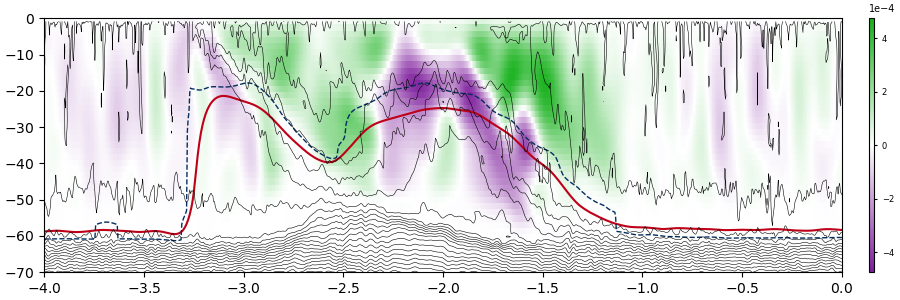

In [63]:
plt.close()
plt.figure(figsize=(9,3), constrained_layout=True)

itime = 48 - 1
y0 = 290
# pcm,_ = pcolor_limits(ds.c.isel(time=itime).sel(yC=y0, method='nearest'), cmap='Spectral_r', clim=[0,1])
# pcm,_ = pcolor_center(ds.w.isel(time=itime).sel(yC=y0, method='nearest'), cmap='w_ds')
# pcm,_ = pcolor_center(dsl.dcdz.isel(time=itime).sel(yC=y0, method='nearest'), cmap='cp')
# pcm,_ = pcolor_center(dsl.wc.isel(time=itime).sel(yC=y0, method='nearest'), cmap='cp')
# pcm,_ = pcolor_limits(np.abs(dsl.nFFcz.isel(time=itime).sel(yC=y0, method='nearest').where(np.abs(dsl.wc).isel(time=itime).sel(yC=y0, method='nearest') >= 1e-5)),
#                       cmap=plt.get_cmap('YlGnBu', 10), clim=[0,1])
pcm,_ = pcolor_center(dsl.w_c.isel(time=itime).sel(yC=y0, method='nearest'), cmap='cp')
# pcm,_ = pcolor_center((ds.w*ds.c).isel(time=itime).sel(yC=y0, method='nearest'), cmap='cp')

plt.plot(dsl.xC/1e3, -dsl.mld.isel(time=itime).sel(yC=y0, method='nearest'), 'xkcd:scarlet')
# plt.plot(dsl.xC/1e3, -dsf.mld.isel(time=itime).sel(yC=y0, method='nearest'), 'xkcd:scarlet')#, ls='--')
plt.plot(dsl.xC/1e3, -dsf.bld.isel(time=itime).sel(yC=y0, method='nearest'), 'xkcd:marine', ls='--', lw=1)
config_colorbar(pcm)

plt.contour(ds.xC/1e3, ds.zC, ds.b.isel(time=itime).sel(yC=y0, method='nearest'), blines_upper, colors='k', linewidths=0.4)
# plt.contour(dsl.xC/1e3, dsl.zC, dsl.b.isel(time=itime).sel(yC=y0, method='nearest'), blines_upper, colors='k', linewidths=0.4)
# plt.contour(dsl.xC/1e3, dsl.zC, dsl.c.isel(time=itime).sel(yC=y0, method='nearest'), np.arange(0.2,1,0.1), colors='gray', linewidths=0.4)
plt.ylim(-70, 0);
# plt.xlim(0, 4);
plt.xlim(-4, -0);

### Volume integrated fine-scale kinetic energy budget

$\frac{\partial }{\partial t} \int\mathcal{E}'dV = \int \Pi dV + \int\mathcal{B}'dV - \int \mathcal{D}'dV$

In [22]:
dxy   = 4*4
dt    = dsl.save_out_interval*3
cbgt0 = dsf.Ifske.where(dsl.mask_fz).sum(['xC', 'yC'])*dxy
cbgt0 = cbgt0 - cbgt0.isel(time=0)
cbgt1 = integrate.cumulative_trapezoid(dsf.ISP.where(dsl.mask_fz).sum(['xC', 'yC'])*dxy,  dx=dt, initial=0)
cbgt2 = integrate.cumulative_trapezoid(dsf.IVBP.where(dsl.mask_fz).sum(['xC', 'yC'])*dxy, dx=dt, initial=0)

cbdgt = np.stack([cbgt1, cbgt2])

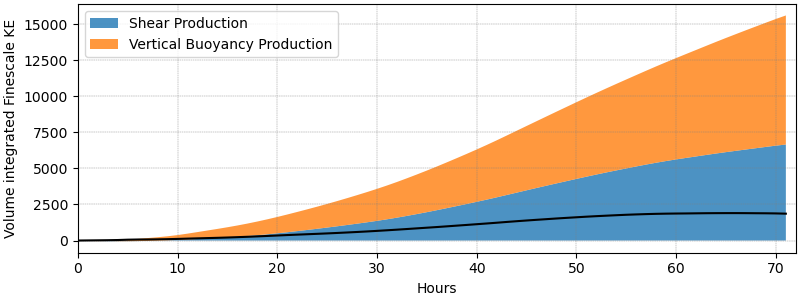

In [23]:
plt.close()
plt.figure(figsize=(8,3), constrained_layout=True)


# plt.stackplot(dsf.day, cbdgt, 
#               labels=['Submesoscale transport', 'Residual transport'], alpha=0.8)

# plt.stackplot(dsf.day, cbdgt, 
#               labels=['Transport outside front',
#                       'Transport inside front: Submesoscale',
#                       'Transport inside front: Residual'], alpha=0.8)

# plt.stackplot(dsf.day, cbdgt, 
#               labels=['Transport outside front',
#                       'Transport inside front: Submesoscale',
#                       'Transport inside front: Residual from Reynolds term',
#                       r"Transport inside front: Residual from Clark term $\overline{\bar{w}c'}$",
#                       r"Transport inside front: Residual from Clark term $\overline{w'\bar{c}}$",
#                       'Transport inside front: Residual from Leonard term'], alpha=0.8)

plt.stackplot(dsf.hour, cbdgt, 
              labels=['Shear Production',
                      'Vertical Buoyancy Production',
                     ], alpha=0.8)

plt.plot(dsf.hour, cbgt0, 'k')
plt.legend()

plt.xlim(0, 72)
# plt.ylim(-1e7, 4.6e8)
plt.grid(c='gray', ls='--', lw=0.3)
plt.ylabel(r'Volume integrated Finescale KE')
plt.xlabel('Hours');